# Tyler Faulkner

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import warnings
import os.path

In [2]:
torch.set_default_dtype(torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)

EPOCHS = 50

# For simple regression problem
TRAINING_POINTS = 1000

# For fashion-MNIST and similar problems
DATA_ROOT = '/data/cs3450/data/'
FASHION_MNIST_TRAINING = '/data/cs3450/data/fashion_mnist_flattened_training.npz'
FASHION_MNIST_TESTING = '/data/cs3450/data/fashion_mnist_flattened_testing.npz'
CIFAR10_TRAINING = '/data/cs3450/data/cifar10_flattened_training.npz'
CIFAR10_TESTING = '/data/cs3450/data/cifar10_flattened_testing.npz'
CIFAR100_TRAINING = '/data/cs3450/data/cifar100_flattened_training.npz'
CIFAR100_TESTING = '/data/cs3450/data/cifar100_flattened_testing.npz'


In [3]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu().
       https://d2l.ai/chapter_deep-learning-computation/use-gpu.html
    """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
DEVICE=try_gpu()
DEVICE

device(type='cuda', index=0)

In [4]:
def create_linear_training_data():
    """
    This method simply rotates points in a 2D space.
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    y = torch.cat((-x2, x1), axis=0)
    return x, y


def create_folded_training_data():
    """
    This method introduces a single non-linear fold into the sort of data created by create_linear_training_data. Be sure to REMOVE the final softmax layer before testing on this data!
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    x2 *= 2 * ((x2 > 0).float() - 0.5)
    y = torch.cat((-x2, x1), axis=0)
    return x, y


def create_square():
    """
    This is the square example that we looked at in class.
    insideness is true if the points are inside the square.
    :return: (points, insideness) the dataset. points is a 2xN array of points and insideness is true if the point is inside the square.
    """
    win_x = [2,2,3,3]
    win_y = [1,2,2,1]
    win = torch.tensor([win_x,win_y],dtype=torch.float32)
    win_rot = torch.cat((win[:,1:],win[:,0:1]),axis=1)
    t = win_rot - win # edges tangent along side of poly
    rotation = torch.tensor([[0, 1],[-1,0]],dtype=torch.float32)
    normal = rotation @ t # normal vectors to each side of poly
        # torch.matmul(rotation,t) # Same thing

    points = torch.rand((2,2000),dtype = torch.float32)
    points = 4*points

    vectors = points[:,np.newaxis,:] - win[:,:,np.newaxis] # reshape to fill origin
    insideness = (normal[:,:,np.newaxis] * vectors).sum(axis=0)
    insideness = insideness.T
    insideness = insideness > 0
    insideness = insideness.all(axis=1)
    return points, insideness

In [5]:
def load_dataset_flattened(train=True,dataset='Fashion-MNIST',download=False):
    """
    :param train: True for training, False for testing
    :param dataset: 'Fashion-MNIST', 'CIFAR-10', or 'CIFAR-100'
    :param download: True to download. Keep to false afterwords to avoid unneeded downloads.
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    if dataset == 'Fashion-MNIST':
        if train:
            path = FASHION_MNIST_TRAINING
        else:
            path = FASHION_MNIST_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-10':
        if train:
            path = CIFAR10_TRAINING
        else:
            path = CIFAR10_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-100':
        if train:
            path = CIFAR100_TRAINING
        else:
            path = CIFAR100_TESTING
        num_labels = 100
    else:
        raise ValueError('Unknown dataset: '+str(dataset))

    if os.path.isfile(path):
        print('Loading cached flattened data for',dataset,'training' if train else 'testing')
        data = np.load(path)
        x = torch.tensor(data['x'],dtype=torch.float32)
        y = torch.tensor(data['y'],dtype=torch.float32)
        pass
    else:
        class ToTorch(object):
            """Like ToTensor, only to a numpy array"""

            def __call__(self, pic):
                return torchvision.transforms.functional.to_tensor(pic)

        if dataset == 'Fashion-MNIST':
            data = torchvision.datasets.FashionMNIST(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-10':
            data = torchvision.datasets.CIFAR10(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-100':
            data = torchvision.datasets.CIFAR100(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        else:
            raise ValueError('This code should be unreachable because of a previous check.')
        x = torch.zeros((len(data[0][0].flatten()), len(data)),dtype=torch.float32)
        for index, image in enumerate(data):
            x[:, index] = data[index][0].flatten()
        labels = torch.tensor([sample[1] for sample in data])
        y = torch.zeros((num_labels, len(labels)), dtype=torch.float32)
        y[labels, torch.arange(len(labels))] = 1
        np.savez(path, x=x.detach().numpy(), y=y.detach().numpy())
    return x, y

In [6]:
# TODO: Select your datasource.
dataset = 'Fashion-MNIST'
# dataset = 'CIFAR-10'
# dataset = 'CIFAR-100'

x_train_lin, y_train_lin = create_linear_training_data()
#x_train, y_train = create_folded_training_data()
#points_train, insideness_train = create_square()
x_train, y_train = load_dataset_flattened(train=True, dataset=dataset, download=False)

# Move selected datasets to GPU
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)


# Move selected datasets to GPU
x_train_lin = x_train_lin.to(DEVICE)
y_train_lin = y_train_lin.to(DEVICE)

Loading cached flattened data for Fashion-MNIST training


In [7]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float32)

In [8]:
y_train

tensor([[0., 1., 1.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float32)

In [9]:
# TODO: Test the accuracy of your network
x_test_lin, y_test_lin = create_linear_training_data()
x_test, y_test = load_dataset_flattened(train=False, dataset=dataset, download=False)

# Move the selected datasets to the GPU
x_test = x_test.to(DEVICE)
y_test = y_test.to(DEVICE)

x_test_lin = x_test_lin.to(DEVICE)
y_test_lin = y_test_lin.to(DEVICE)

Loading cached flattened data for Fashion-MNIST testing


In [10]:
x_test.size()

torch.Size([784, 10000])

In [11]:
y_test.size()

torch.Size([10, 10000])

In [12]:
def compute_layer(W, x, b):
    return W@x + b

def RELU(layer):
    return layer*(layer>0)

In [13]:
#Test 1
x=torch.tensor([[3.],[4.]])
W1 = torch.tensor([[1.,2.],[0.,3.],[-2.,1.]])
W2 = torch.tensor([[2.,3.,-2.],[4.,0.,1.]])
b1 = torch.tensor([[0.5],[1.2],[3.]])
b2 = torch.tensor([[-1.],[1.]])

L = compute_layer(W1, x, b1)

compute_layer(W2, L, b2)

tensor([[59.6000],
        [48.0000]])

In [14]:
#Test 2
x=torch.tensor([[1.],[3.]])
W1 = torch.tensor([[-2.,4.],[3.,2.],[1.,1.]])
W2 = torch.tensor([[3.,3.,4.],[2.,-1.,3.]])
b1 = torch.tensor([[0.7],[-4.],[0.2]])
b2 = torch.tensor([[-3.],[-2.]])

L = compute_layer(W1, x, b1)

compute_layer(W2, L, b2)

tensor([[60.9000],
        [27.0000]])

In [15]:
W1 = torch.randn((3,2), requires_grad=True, device=DEVICE)
W2 = torch.randn((2,3), requires_grad=True, device=DEVICE)
b1 = torch.zeros((3,1), requires_grad=True, device=DEVICE)
b2 = torch.zeros((2,1), requires_grad=True, device=DEVICE)

with torch.no_grad():
    W1 *= 0.1
    W2 *= 0.1

l_rate = 0.0001
alpha = 0.00001
epochs = 500

## Lab 3

In [16]:
#Batch Training

def learn_linear(x_train, y_train):
    W1 = torch.randn((3,2), requires_grad=True, device=DEVICE)
    W2 = torch.randn((2,3), requires_grad=True, device=DEVICE)
    b1 = torch.zeros((3,1), requires_grad=True, device=DEVICE)
    b2 = torch.zeros((2,1), requires_grad=True, device=DEVICE)

    with torch.no_grad():
        W1 *= 0.1
        W2 *= 0.1

    l_rate = 0.0001
    alpha = 0.00001
    epochs = 1000
    batch_size = 64


    for i in range(epochs):

        for s in range(batch_size, x_train.size()[1], batch_size):
            sample = x_train[:, s-batch_size:s]
            y_sample = y_train[:, s-batch_size:s]

            L= RELU(compute_layer(W1, sample, b1))

            O = compute_layer(W2, L, b2)

            Error = 1/len(y_sample)*torch.sum((y_sample-O)**2)

            Regularization = W1.data.pow(2).sum() + W2.data.pow(2).sum()

            Loss = Error + alpha*Regularization

            Loss.backward()

            #print(Loss)

            with torch.no_grad():
                W1 -= alpha*W1.grad
                W2 -= alpha*W2.grad
                b1 -= alpha*b1.grad
                b2 -= alpha*b2.grad

            W1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()
            b1.grad.zero_()
    L= RELU(compute_layer(W1, x_train, b1))
    O = compute_layer(W2, L, b2)

    predicted_classes = torch.argmax(O,0)
    true_classes = torch.argmax(y_train,0)
    total = y_train.size()[1]
    print("Accuracy: ", ((predicted_classes==true_classes).sum()/total).item())
    print()
    print("Matrix used to generate data:")
    print(W2 @ W1)
    print(Loss)
#learn_linear(x_train_lin, y_train_lin)

## Lab 4

In [17]:
import math
def SOFTMAX(out):
    z = out - torch.max(out, 0).values
    num = torch.exp(z)
    denom = num.sum(axis=0)
    return num/denom
print(DEVICE)
SOFTMAX(torch.tensor([[1.,6.,5.],[2.,3.,5.]], device=DEVICE))

cuda:0


tensor([[0.2689, 0.9526, 0.5000],
        [0.7311, 0.0474, 0.5000]], device='cuda:0')

In [18]:
class Layer():
    def __init__(self, neurons):
        self.neurons = neurons

In [19]:
class Hidden(Layer):
    def __init__(self, neurons, last_layer_neurons, activation=RELU, DEVICE=DEVICE):
        super().__init__(neurons)
        self.input = last_layer_neurons
        self.W = torch.randn((neurons, last_layer_neurons), requires_grad=True, device=DEVICE)
        with torch.no_grad():
            self.W *= 0.1
        self.b = torch.zeros((neurons, 1), requires_grad=True, device=DEVICE)
        self.activation = activation
    def get_W(self):
        return self.W
    def forward(self, x):
        if self.activation != None:
            return self.activation(self.W.double()@x + self.b.double())
        else:
            return self.W@x + self.b
    def backward(self, lr):
        with torch.no_grad():
            self.W -= lr * self.W.grad
            self.b -= lr * self.b.grad
        self.W.grad.zero_()
        self.b.grad.zero_()
    def print(self):
        print("Hidden layer with", self.neurons, " output neurons,", self.input, " input neurons,", self.activation.__name__, "activation function")

In [20]:
class Output(Hidden):
    def __init__(self, neurons, last_layer_neurons, activation=SOFTMAX, DEVICE=DEVICE):
        super().__init__(neurons, last_layer_neurons, activation, DEVICE)
    def print(self):
        act_name = "None"
        if self.activation != None:
            act_name=self.activation.__name__
        print("Output layer with", self.neurons, " output neurons,", self.input, " input neurons,", act_name, "activation function")

In [21]:
from sklearn.metrics import accuracy_score
import math

class Network():
    def __init__(self, layers, reg_coef, lr, loss="l2"):
        self.layers = layers
        self.output = None
        self.reg_coef = reg_coef
        self.lr = lr
        self.loss = loss
    def _loss(self, final, s_out):
        reg = self._reg()
        if self.loss=="l2":
            error = self._l2(final, s_out)
        elif self.loss=="cross":
            error = self._cross(final, s_out)
        loss = error + self.reg_coef*reg
        return loss
    
    def _cross(self, output, true):
        #1e-7 if going to zero
        z = torch.sum((true*torch.log(output)))
        return -z/true.size()[1]
    
    def _l2(self, sample, s_out):
        return 1/len(s_out)*torch.sum((s_out-sample)**2)
    
    def _reg(self):
        total = 0
        for i in range(len(self.layers)):
            total += self.layers[i].get_W().data.pow(2).sum()
        return total
    
    def _backprop(self):
        for i in range(len(self.layers)):
            self.layers[i].backward(self.lr)
            
    def forward(self, x):
        out = x
        for i in range(len(self.layers)):
            out = self.layers[i].forward(out)
        return out
    
    def test(self, x, y):
        with torch.no_grad():
                output = (self.forward(x))
                loss = self._loss(output, y).item()
                print("Loss ", loss)
                predicted_classes = torch.argmax(output,0)
                true_classes = torch.argmax(y,0)
                total = y.size()[1]
                accuracy = ((predicted_classes==true_classes).sum()/total).item()
                print("Accuracy: ", accuracy)
                print()
                return accuracy, loss
    def train(self, epochs, batch_size, x_train, y_train):
        accuracies = []
        losses = []
        for e in range(epochs):
            entries = x_train.size()[1]
            front_p = 0
            end_p = batch_size
            if(batch_size > x_train.size()[1]):
                end_p = x_train.size()[1]
            while front_p < x_train.size()[1]:
                sample = x_train[:, front_p:end_p]
                y_sample = y_train[:, front_p:end_p]
                final = self.forward(sample)
                self._loss(final, y_sample).backward()
                self._backprop()
                end_p += batch_size
                front_p += batch_size
                if end_p > x_train.size()[1]:
                    end_p = x_train.size()[1]
            print("Epoch", e+1, "results:")
            acc, loss = self.test(x_train, y_train)
            accuracies.append(acc)
            losses.append(loss)
        return accuracies, losses

In [22]:
def create_model(hidden_neurons, input_nodes, output_nodes, reg_coef, lr, loss, last_activation):
    layers = [Hidden(hidden_neurons[0], input_nodes)]
    for i in range(1, len(hidden_neurons)):
        n = hidden_neurons[i]
        layer = Hidden(n, layers[i-1].neurons)
        layers.append(layer)
    out = Output(output_nodes, layers[len(layers)-1].neurons)
    layers.append(Output(output_nodes, layers[len(layers)-1].neurons, activation=last_activation))
    for i in layers:
        i.print()
    return Network(layers, reg_coef, lr, loss=loss)

In [23]:
import time
import matplotlib.pyplot as plt

def train_and_test(hidden_neurons, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test):
    network = create_model(hidden_neurons, x_train.size()[0], y_train.size()[0], reg_coef, lr, loss, last_activation)
    accuracies = None
    start = time.perf_counter()
    accuracies, losses = network.train(epochs, batch_size, x_train.double(), y_train)
    end = time.perf_counter()
    
    
    print("Test Set Accuracy")
    network.test(x_test.double(), y_test)
    print("The training took", end-start, "seconds to finish")
    
    fig, ax1 = plt.subplots()
    epoch_axis = range(1, len(accuracies)+1)
    ax1.plot(epoch_axis, accuracies, label="accuracy")
    ax1.scatter(epoch_axis, accuracies, s=7, color='g')

    ax2 = ax1.twinx() 
    ax2.plot(epoch_axis, losses, c='r', label="loss")
    ax2.scatter(epoch_axis, losses, s=7, c='y')
    plt.title("Accuracy Plot")
    plt.xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")
    fig.legend()
    fig.tight_layout()
    plt.show()

## Attempts:

In [24]:
#First Attempt
reg_coef = 0.0
lr = 0.0001
batch_size = 64
epochs = 30
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [25]:
#Attempt 2
reg_coef = 0.0
lr = 0.0001
batch_size = 64
epochs = 90
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [26]:
#Attempt 3
reg_coef = 0.0001
lr = 0.0001
batch_size = 64
epochs = 90
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [27]:
#Attempt 4
reg_coef = 0.0001
lr = 0.0001
batch_size = 64
epochs = 180
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [28]:
#Attempt 5
reg_coef = 0.0001
lr = 0.0001
batch_size = 64
epochs = 240
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [29]:
#Attempt 6
reg_coef = 0.0001
lr = 0.0001
batch_size = 32
epochs = 240
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [30]:
#Attempt 7
reg_coef = 0.0001
lr = 0.0001
batch_size = 32
epochs = 300
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [31]:
#Attempt 8
reg_coef = 0.0001
lr = 0.001
batch_size = 256
epochs = 150
layers = [28, 14, 10]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [32]:
#Attempt 9
reg_coef = 0.0001
lr = 0.001
batch_size = 256
epochs = 150
layers = [14, 7]
loss = "cross"
last_activation = SOFTMAX

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

Hidden layer with 14  output neurons, 784  input neurons, RELU activation function
Hidden layer with 7  output neurons, 14  input neurons, RELU activation function
Output layer with 10  output neurons, 7  input neurons, SOFTMAX activation function
Epoch 1 results:
Loss  2.3119078294009245
Accuracy:  0.14733333333333334

Epoch 2 results:
Loss  2.3085772770600936
Accuracy:  0.17101666666666668

Epoch 3 results:
Loss  2.304304189158646
Accuracy:  0.1764

Epoch 4 results:
Loss  2.2981232906027085
Accuracy:  0.17556666666666668

Epoch 5 results:
Loss  2.28850781566751
Accuracy:  0.17195000000000002

Epoch 6 results:
Loss  2.2734574103331737
Accuracy:  0.17308333333333334

Epoch 7 results:
Loss  2.250436178039167
Accuracy:  0.17995

Epoch 8 results:
Loss  2.2160219966026182
Accuracy:  0.19838333333333336

Epoch 9 results:
Loss  2.16672721991862
Accuracy:  0.22428333333333333

Epoch 10 results:
Loss  2.099891666436261
Accuracy:  0.25253333333333333

Epoch 11 results:
Loss  2.011761031228887
A

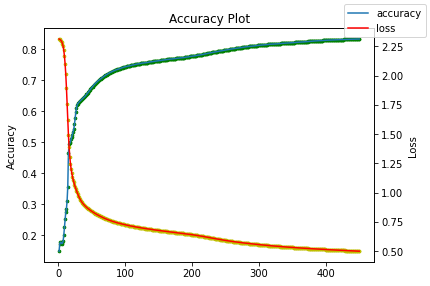

In [33]:
#Attempt 10
reg_coef = 0.0001
lr = 0.01
batch_size = 1024
epochs = 450
layers = [14, 7]
loss = "cross"
last_activation = SOFTMAX

train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train, y_train, x_test, y_test)

In [34]:
#Test on Lin Data
lr = 0.0001
reg_coef = 0.0001
epochs = 100
batch_size = 16
loss= "l2"
last_activation = None
layers=[3]

#train_and_test(layers, lr, epochs, batch_size, reg_coef, loss, last_activation, x_train_lin, y_train_lin, x_test_lin, y_test_lin)

##### 